---
## **Covid-19 image classification**
---

# **Abstract**

Σκοπός της εργασίας αυτής είναι η ταξινόμηση εικόνων υπολογιστικής τομογραφίας, οι οποίες αφορούν ασθενείς που είτε έχουν μολυνθεί από τον ιό SARS-CoV-2 είτε όχι.

Το σύνολο δεδομένων περιέχει συνολικά 2482 τομές υπολογιστικής τομογραφίας εκ των οποίων 1252 αφορούν θετικούς για κορωνοϊο ασθενείς και  1230 αφορούν αρνητικούς ασθενείς.

Τα δεδομένα αυτά, έχουν συλλεχθεί από πραγματικούς ασθενείς του νοσοκομείου του Σαο Πάολο της Βραζιλίας.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121

# **Εισαγωγή**

Στις μέρες μας η ιατρική απεικόνιση έχει εξελιχθεί σημαντικά σε τόσο μεγάλο βαθμό που πλέον είναι δυνατή η λήψη πολλών βιοϊατρικών εικόνων από ασθενείς σε σύντομα χρονικά διαστήματα.

Οι ιατρικές εικόνες χρησιμοποιούνται ευρέως για την εκπαίδευση συστημάτων στήριξης ιατρικών αποφάσεων. Σκοπός τέτοιων συστημάτων είναι να βοηθήσουν εξειδικευμένους επιστήμονες όσον αφορά στη διάγνωση διαφορετικών ασθενειών με όσο πιο μεγάλη ακρίβεια γίνεται.

Η ταξινόμηση παίζει πολύ σημαντικό ρόλο σε αυτή την διαδικασία. Αφορά στον διαχωρισμό των εικόνων σε διακριτές ομάδες και συμβάλλει στην ενίσχυση διαγνωστικών διαδικασιών με την βοήθεια υπολογιστών.

Όσον αφορά στην μηχανική μάθηση, η ταξινόμιση έχει να κάνει με την ταύτιση δεδομένων σε συγκεκριμένες κατηγορίες.


# **Σύνδεση του google colab με το google drive**

Όταν γίνεται διακοπή ενός session στο google colab τότε χάνονται όλα τα δεδομένα τα οποία έχουμε ανεβάσει, με αποτέλεσμα να πρέπει να γίνει reupload για να χρησιμοποιηθεί σωστά το notebook.

Για να μην υπάρχει σπατάλη χρόνου, μπορούμε να συνδέσουμε το google colab με το google drive έτσι ώστε να μην χρειάζεται να περιμένουμε να ανέβουν τα δεδομένα κάθε φορά που θα τρέχουμε νέο session (θα πρέπει προφανώς να έχουμε ανεβάσει από πριν τα δεδομένα στο google drive για να είναι εφικτό αυτό).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/SARS_COV-2_Ct-Scan_Dataset'
image_dir = os.path.join(data_dir)

In [4]:
image_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(image_dir, sp)):
        image_data.append(['{}/{}'.format(sp, file), defects_id, sp])

df = pd.DataFrame(image_data, columns=['File', 'DiseaseID','Disease Type'])
df.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (272).png,0,COVID
1,COVID/Covid (226).png,0,COVID
2,COVID/Covid (1232).png,0,COVID
3,COVID/Covid (265).png,0,COVID
4,COVID/Covid (231).png,0,COVID


# Dataset randomization

In [5]:
# Κάνουμε shuffle τις γραμμές του dataframe.
# Χρησιμοποιούμε random seed για να υπάρχει επαναληψιμότητα
SEED = 42
df = df.sample(frac=1, random_state=SEED) # Κάνε sample όλες τις σειρές του dataframe (το frac=1 δηλώνει ότι γίνεται για όλες τις σειρές).
df.index = np.arange(len(df)) # Reset indices
df.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (382).png,0,COVID
1,COVID/Covid (477).png,0,COVID
2,non-COVID/Non-Covid (635).png,1,non-COVID
3,non-COVID/Non-Covid (621).png,1,non-COVID
4,COVID/Covid (757).png,0,COVID


# Label frequency
Είναι σημαντικό να δούμε την συχνότητα των εικόνων έκαστης κατηγορίας στο σύνολο δεδομένων. Σε περίπτωση που η συχνότητα μιας κατηγορίας εικόνων είναι μεγαλύτερη σε σχέση με την άλλη (πχ: οι εικόνες που έχουν το tag: COVID είναι περισσότερες σε σχέση με αυτές που έχουν το tag: non-COVID) τότε θα έχουμε ένα ανισόρροπο σύνολο δεδομένων (aka: imbalanced dataset).



Στην περίπτωση που μελετάται, δεν υπάρχει αυτό το πρόβλημα καθώς παρατηρούμε ότι οι συχνότητες των δύο κατηγοριών είναι σχεδόν ίσες.

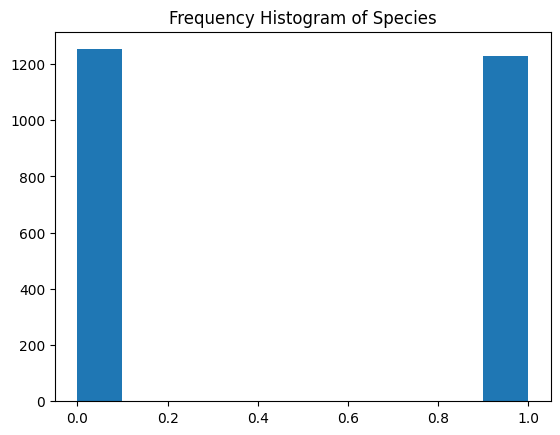

<Figure size 1200x1200 with 0 Axes>

In [6]:
plt.hist(df['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [ ]:
!pip install wordcloud

## Image display function

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

## Display Covid images

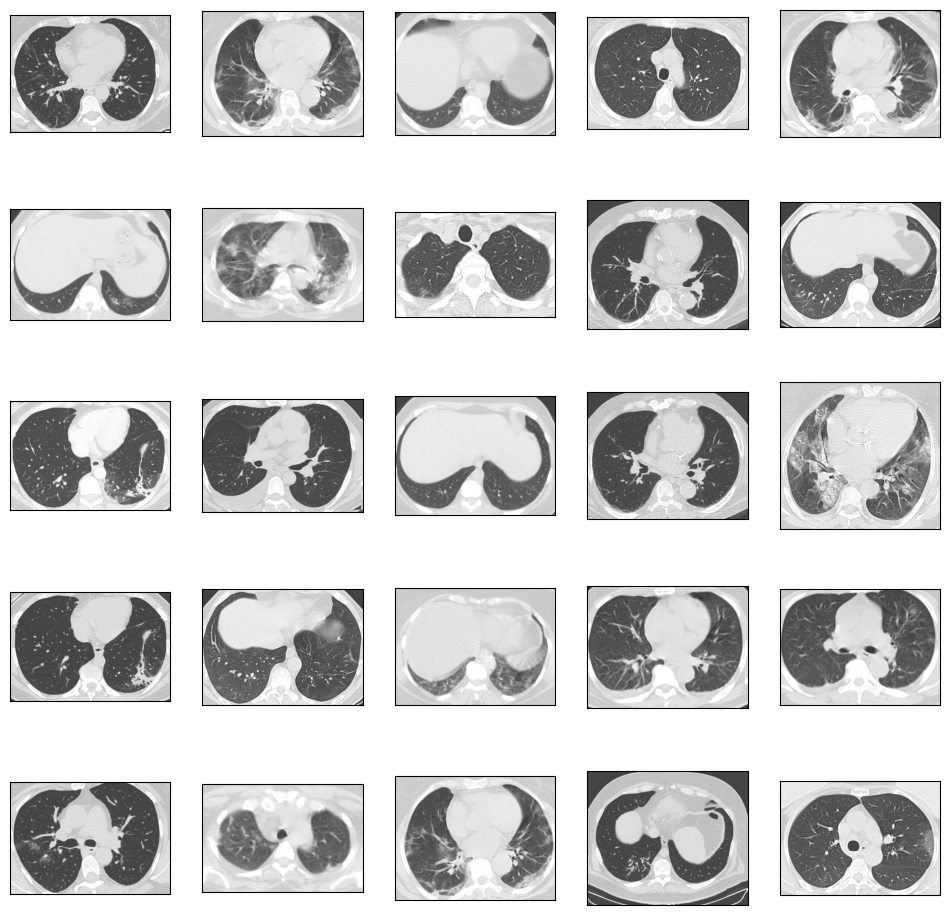

In [8]:
# Displays first n covid images from the dataset
plot_defects('COVID', 5, 5)

## Display non-Covid images


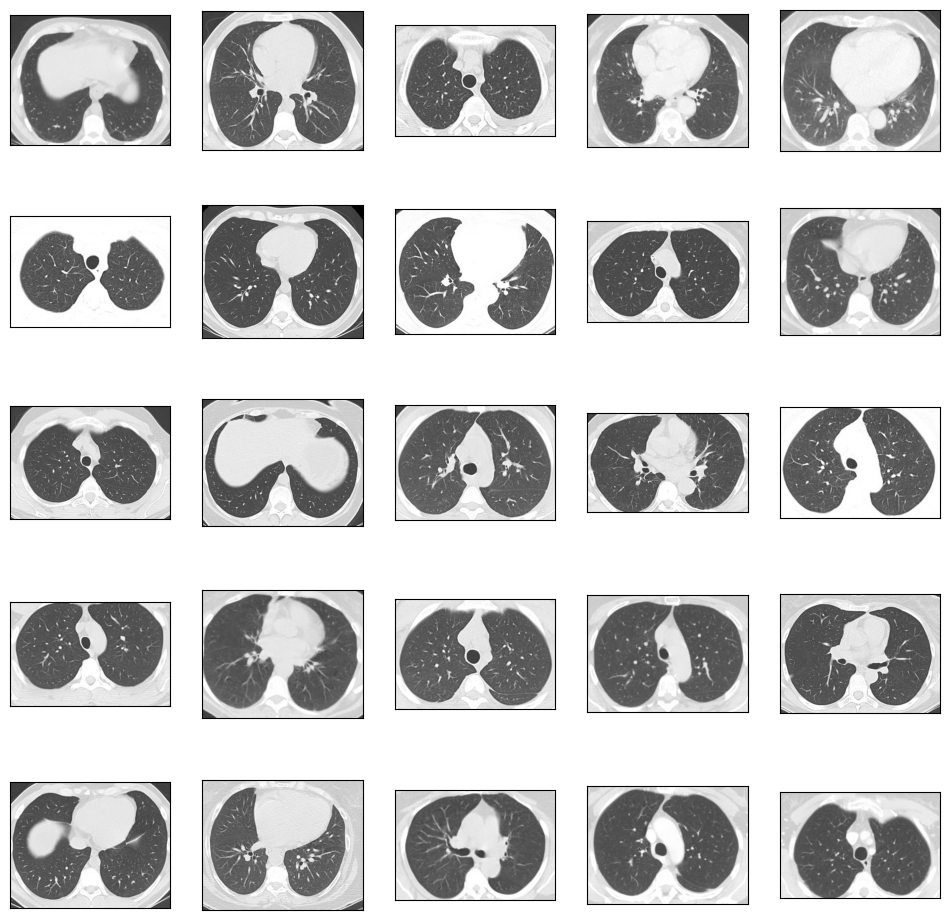

In [9]:
# Displays first n non-covid images from the dataset
plot_defects('non-COVID', 5, 5)

# Reading and resizing images
Είναι απαραίτητο να τροποποιήσουμε τις εικόνες του συνόλου δεδομένων έτσι ώστε να έρθουν όλες στο ίδιο μέγεθος. Πριν την επεξεργασία, κάθε εικόνα έχει διαφορετικό μέγεθος (πχ: η εικόνα COVID(1246) έχει μέγεθος 370x326x3, ενώ η εικόνα COVID(1251) έχει μέγεθος 378x331x3). Το ίδιο ισχύει και για τις non-COVID εικόνες τους συνόλου δεδομένων.

In [10]:
# Το interpolation έχει να κάνει με την μέθοδο που χρησιμοποιούμε για το resizing της εικόνας.
# Εδώ χρησιμοποιείται η τεχνική inter_area της opencv η οποία προτείνεται όταν το resize έχει να κάνει με σμίκρυνση εικόνων.
# Αξιοποιεί πληροφορία που έχει να κάνει με το εμβαδόν κάθε pixel.
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize της εικόνας στο ζητούμενο μέγεθος.
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [11]:
# Δημιουργείται ένας καμβάς από μηδενικά μεγέθους (df.shape, IMAGE_SIZE, IMAGE_SIZE, 3).
# Αυτό διότι θέλουμε να κάνουμε resize σε όλες τις εικόνες του συνόλου δεδομένων μας.
# Άρα "εφαρμόζουμε" όλες τις εικόνες που έχουμε μέσα σε έναν τέτοιο "καμβά".
X = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(df['File'].values)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Κανονικοποίηση εικόνων
X = X / 255.
print('Train Shape: {}'.format(X.shape))

2481it [12:22,  3.34it/s]

Train Shape: (2481, 64, 64, 3)


# Label conversion
Θέλουμε να κάνουμε one-hot encoding όσον αφορά τα tags που έχουμε. Δηλαδή αντί για 0 ή 1 θέλουμε κάθε tag να αντιπροσωπεύεται από ένα διάνυσμα δύο διαστάσεων ((1.,0.) ή (0., 1.)).

In [12]:
Y = df['DiseaseID'].values
Y

array([0, 0, 1, ..., 0, 1, 0])

In [13]:
Y2cat = to_categorical(Y, num_classes=2)
Y2cat

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Train, validation and test split
Για να γίνει σωστά η εκπαίδευση ενός μοντέλου μηχανικής μάθησης, είναι απαραίτητο να χωρίσουμε το σύνολο δεδομένων σε υποσύνολα εκπαίδευσης (training), αξιολόγησης (validation) και δοκιμής (testing).

To training set χρησιμοποιείται για την εκπαίδευση του μοντέλου μηχανικής μάθησης και το validation set χρησιμοποιείται για την αξιολόγηση του μοντέλου κατά την διάρκεια της εκπαίδευσης (γίνεται τροποποίηση παραμέτρων υψηλότερου επιπέδου έτσι: fine tuning).

Το test set είναι το σύνολο δεδομένων που θα χρησιμοποιηθεί εφόσον έχει ολοκληρωθεί η διαδικασία εκπαίδευσης του μοντέλου. Αποτελείται από στοιχεία/δεδομένα τα οποία δεν έχει "δει" ξανά το μοντέλο και βοηθάει στο να έχουμε μια εικόνα σχετικά με την απόδοση του εκπαιδευμένου μοντέλου σε νέα δεδομένα

In [14]:
# Split dataset to training and remaining subsets
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y2cat, train_size=0.8, random_state=SEED)

# Split remaining subset to validation and testing subsets
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=SEED)

In [15]:
# Print shapes of subsets
print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(1984, 64, 64, 3)
(1984, 2)
(248, 64, 64, 3)
(248, 2)
(249, 64, 64, 3)
(249, 2)


(None, None)

# Train set image display (images are resized)

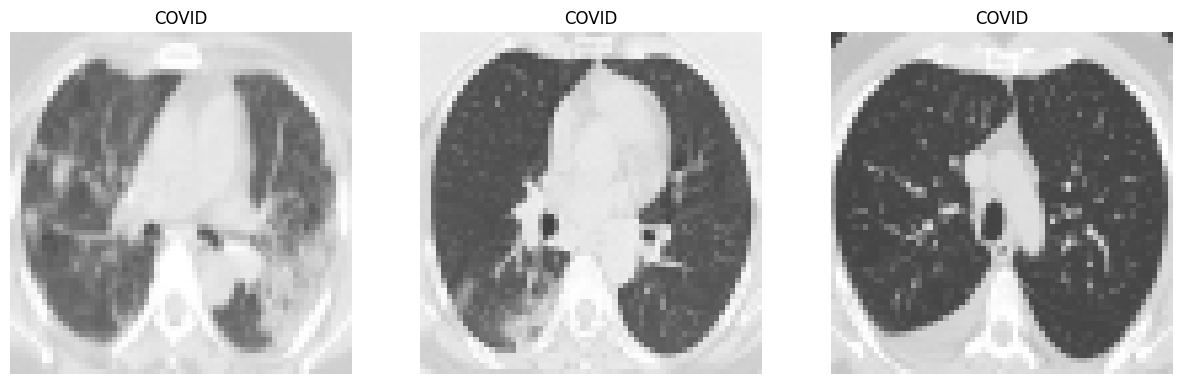

In [16]:
# Εδώ βλέπουμε κάποιες από τις εικόνες του συνόλου εκπαίδευσης
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [17]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

#### Το perceptron

- Το building block για τα τεχνητά νευρωνικά δίκτυα (ANN).

- Εφευρέθηκε το 1957 από τον Frank Rosenblatt.

- Είναι μια μαθηματική συνάρτηση η οποία βασίζεται σε ένα μοντέλο βιολογικών νευρώνων. Σύμφωνα με το μοντέλο, κάθε νευρώνας λαμβάνει τιμές εισόδου στις οποίες δίνει διαφορετικά βάρη, τις αθροίζει και στη συνέχεια τις περνάει μέσα από μια μη-γραμμική συνάρτηση έτσι ώστε να παραχθεί μια έξοδος.

<img src="./images/perceptron_example.png" width="500" height="340"> 

- Ένα perceptron αποτελείται από τα παρακάτω στοιχεία:

    1) Στρώμα εισόδου: έχει μια (ή παραπάνω) οι οποίες λαμβάνουν "σήματα" εισόδου είτε από τον εξωτερικό κόσμο είτε από προηγούμενα στρώματα του τεχνητού νευρωνικού δικτύου.

    2) Βάρη: κάθε είσοδος, έχει μια συγκεκριμένη τιμή βάρους, η οποία αντιπροσωπεύει τη δύναμη της σύνδεσης μεταξύ της εισόδου και της εξόδου. Με πιο απλά λόγια, τα βάρη αντιπροσωπεύουν τη σημαντικότητα κάθε χαρακτηριστικού όσον αφορά στην τελική πρόβλεψη. 

    3) Bias: είναι ένας όρος που προστίθεται στο στρώμα εισόδου έτσι ώστε να δώσει στο perceptron ένα επιπλέον επίπεδο ευελιξίας όσον αφορά στη μοντελοποίηση περίπλοκων προτύπων στα δεδομένα εισόδου. Επιτρέπει στο perceptron, να "λαμβάνει υπόψιν" και περιπτώσεις όπου οι είσοδοι δεν είναι αρκετές όσον αφορά στην μοντελοποίηση της πολυπλοκότητας του προβλήματος προς επίλυση.

    4) Συνάρτηση ενεργοποίησης: καθορίζει την έξοδο του perceptron με βάση το βεβαρυμένο άθροισμα του στρώματος εισόδου. Προσδίδει μη-γραμμικότητα στο μοντέλο. Επί της αρχής είναι το κομμάτι του perceptron το οποίο ελέγχει αν ο τεχνητός νευρώνας θα πυροδοτηθεί ή όχι.

Τεχνητά Νευρωνικά Δίκτυα

- Είναι γνωστά και ως (MLPs), αποτελούνται από ένα στρώμα εισόδου, ενδοιάμεσα στρώματα τεχνητών νευρώνων και ένα τελικό στρώμα νευρώνων που ονομάζεται στρώμα εξόδου.

- Ο πιο γνωστός τύπος τεχνητών νευρωνικών δικτύων είναι αυτός όπου το σήμα "κυλάει" από την είσοδο προς την έξοδο σε μια μόνο κατεύθυνση.Είναι γνωστά και ως αρχιτεκτονικές πρόσθιας διάδοσης (feed-forward architectures).

<img src="./images/neural_network_example.png" width="400" height="340" align="center"> 

#### Back propagation

- Ένα νευρωνικό δίκτυο μπορεί να θεωρηθεί ως μια σύνθετη συνάρτηση που αντιστοιχίζει δεδομένα εισόδου σε προβλέψεις (έξοδοι). Τα βάρη του δικτύου καθορίζουν τον τρόπο με τον οποίο τα δεδομένα εισόδου μετασχηματίζονται μέσω κάθε στρώματος προκειμένου να παραχθεί η έξοδος.

- Κατά τη διάρκεια του forward pass τα δεδομένα ρέουν μέσω του δικτύου, στρώμα προς στρώμα, μέχρι να παραχθεί μια έξοδος. Αυτή η έξοδος είναι η τρέχουσα πρόβλεψη του δικτύου, με βάση τα βάρη του τη δεδομένη στιγμή.

- Μετά το εμπρόσθιο πέρασμα η πρόβλεψη των δικτύων συγκρίνεται με τον πραγματικό στόχο μέσω της χρήσης μιας συνάρτησης σφάλματος. Η συνάρτηση απώλειας ποσοτικοποιεί τη διαφορά μεταξύ της πρόβλεψης και δεδομένης αλήθειας. Στόχος είναι η ελαχιστοποίηση αυτής της συνάρτησης απωλειών (ώστε το δίκτυο να κάνει ακριβείς προβλέψεις).

- Backward pass (υπολογισμός κλίσης): προσδιορίζει τον τρόπο με τον οποίο κάθε βάρος συμβάλλει στην απώλεια με τον υπολογισμό της κλίσης της συνάρτησης απώλειας σε σχέση με κάθε βάρος. Αυτό μας λέει την κατεύθυνση προς την οποία πρέπει να προσαρμοστεί κάθε ένα από τα βάρη προκειμένου να μειωθεί η απώλεια.

- Ενημέρωση βαρών (gradient descent): οι υπολογισμένες κλίσεις χρησιμοποιούνται στη συνέχεια για την προσαρμογή των βαρών προς την αντίθετη κατεύθυνση της κλίσης. Αυτό γίνεται στρώμα προς στρώμα ξεκινώντας από το στρώμα εξόδου και προχωρώντας προς τα πίσω (εξ ου και η ονομασία back propagation). Εάν η κλίση είναι θετική (η απώλεια αυξάνεται με το βάρος), τότε το βάρος μειώνεται. Εάν η κλίση είναι αρνητική (η απώλεια μειώνεται με το βάρος), τότε το βάρος αυξάνεται. Η κλίση στην κάθοδο κλίσης αντιπροσωπεύει τις μερικές παραγώγους της συνάρτησης απώλειας ως προς κάθε ένα από τα βάρη του μοντέλου. Ουσιαστικά, είναι ένα διάνυσμα που δείχνει προς την κατεύθυνση της πιο απότομης αύξησης της συνάρτησης απώλειας. Η κλίση μας λέει πώς να αλλάξουμε κάθε βάρος για να μειώσουμε την απώλεια, με κάθε συνιστώσα του διανύσματος κλίσης να αντιστοιχεί σε ένα διαφορετικό βάρος στο μοντέλο.

- Το backward pass και το gradient descent, συνιστούν το back propagation.

- Πρόκειται για μια επαναληπτική διαδικασία που επαναλαμβάνεται έως ότου το δίκτυο συγκλίνει σε μια κατάσταση όπου οι απώλειες ελαχιστοποιούνται και οι προβλέψεις που γίνονται από το μοντέλο είναι όσο το δυνατόν πιο ακριβείς.

<img src="./images/gradient_descent.gif" width="400" height="340" align="center"> 

#### Περιορισμοί των κλασικών ANN στην ανάλυση εικόνας

- Υψηλή διαστατικότητα: τα τεχνητά νευρωνικά δίκτυα, απαιτούν διανυσματοποίηση των εισόδων, γεγονός που οδηγεί σε χώρους εισόδου πολύ υψηλών διαστάσεων για τις εικόνες. Αυτό καθιστά τα μοντέλα μεγάλα και υπολογιστικά δαπανηρά, καθώς κάθε εικονοστοιχείο γίνεται ξεχωριστό χαρακτηριστικό.

- Απώλεια χωρικής ιεραρχίας: Με την ισοπέδωση των εικόνων σε διανύσματα, τα ANN χάνουν τη χωρική ιεραρχία και την τοπικότητα των χαρακτηριστικών. Σημαντικές πληροφορίες σχετικά με τη δομή και τη σχέση των χαρακτηριστικών μέσα σε μια εικόνα δεν αξιοποιούνται αποτελεσματικά.

- Έκρηξη παραμέτρων: Ο αριθμός των παραμέτρων στα ANN αυξάνεται ραγδαία με το μέγεθος του στρώματος εισόδου και τον αριθμό των κρυφών στρωμάτων. Για τις εικόνες, αυτό μπορεί να οδηγήσει σε έκρηξη του αριθμού των παραμέτρων, καθιστώντας το δίκτυο δύσκολο να εκπαιδευτεί και επιρρεπές σε υπερπροσαρμογή.

- Αναποτελεσματικότητα στην εκμάθηση χαρακτηριστικών: Τα ANN αντιμετωπίζουν τα χαρακτηριστικά εισόδου ανεξάρτητα και δεν λαμβάνουν υπόψη τη συσχέτιση μεταξύ γειτονικών εικονοστοιχείων στις εικόνες. Αυτό τα καθιστά αναποτελεσματικά στην εκμάθηση χωρικών ιεραρχιών χαρακτηριστικών που είναι κρίσιμα για την κατανόηση εικόνων.

- Γι' αυτόυς τους λόγους δημιουργήθηκαν τα συνελικτικά νευρωνικά δίκτυα (CNN).

# Συνελικτικά νευρωνικά δίκτυα (CNN)

- Είναι ο πιο διαδεδομένος τύπος δικτύου που χρησιμοποιείται σε εφαρμογές επεξεργασίας και ανάλυσης εικόνας.

- Χρησιμοποιούν μια σειρά από επίπεδα, καθένα από τα οποία ανιχνεύει διαφορετικά χαρακτηριστικά μιας εικόνας εισόδου.

- Ανάλογα με την πολυπλοκότητα του επιδιωκόμενου σκοπού του, ένα CNN μπορεί να περιέχει δεκάδες, εκατοντάδες ή ακόμη και χιλιάδες στρώματα, καθένα από τα οποία βασίζεται στις εξόδους των προηγούμενων στρωμάτων για την αναγνώριση λεπτομερών μοτίβων.

### Στρώματα Συνέλιξης (Convolutional Layers)

- Λειτουργούν σαν μεγεθυντικός φακός που εντοπίζει συγκεκριμένα χαρακτηριστικά σε μικρά τμήματα της εικόνας (ακμές, χρώματα, υφές κ.λπ.).

- Χρησιμοποιούν φίλτρα (γνωστά και ως πυρήνες), προκειμένου να βρίσκουν και να ενεργοποιούνται κατά την αναγνώριση συγκεκριμένων μοτίβων (για παράδειγμα, κατά την εύρεση των μουστάκια μιας γάτας σε μια εικόνα).

- Το φίλτρο ολισθαίνει πάνω στην εικόνα και έτσι δημιουργείται ένας χάρτης χαρακτηριστικών. Το ανθρώπινο ισοδύναμο αυτής της διαδικασίας είναι η εύρεση ακμών και απλών χρωμάτων σε εικόνες.

- Στόχος τους είναι να βοηθήσουν το μοντέλο να εστιάσει σε σημαντικές λεπτομέρειες που βρίσκονται μέσα στην εικόνα.

- Ωστόσο, προκειμένου να πραγματοποιηθεί ακριβέστερη ταξινόμηση, πρέπει να ανιχνεύονται από το δίκτυο και πιο σύνθετα χαρακτηριστικά.

<img src="./images/convolution_schematic.gif" width="600" height="400" align="center"> 

### Στρώματα ReLU

- Περιέχουν μια ειδική συνάρτηση ενεργοποίησης που ονομάζεται Rectified Linear Unit (ReLU).

- Η συνάρτηση αυτή εφαρμόζεται στον χάρτη χαρακτηριστικών που έχει δημιουργηθεί από το επίπεδο συνέλιξης.

- Αυξάνει τη μη γραμμικότητα της εικόνας και αφαιρεί επίσης τις αρνητικές τιμές (ουσιαστικά βελτιώνει την ανάλυση της εικόνας).

- Στόχος της είναι να βοηθήσει τη συνέλιξη να ανιχνεύσει πιο σύνθετα χαρακτηριστικά στην εικόνα.

### Στρώματα pooling

- Απλοποιούν τις πληροφορίες από τα επίπεδα συνέλιξης μειώνοντας το μέγεθος της εικόνας.

- Ουσιαστικά αναζητούν μικρότερες περιοχές στις εικόνες προκειμένου να διατηρήσουν μόνο τα πιο εμφανή χαρακτηριστικά (τις ισχυρότερες ακμές για παράδειγμα).

- Με αυτόν τον τρόπο μειώνουν το πλήθος των παραμέτρων του δικτύου και εξασφαλίζουν επίσης ότι τα σημαντικά/εξέχοντα χαρακτηριστικά της εικόνας θα ανιχνεύονται από το μοντέλο ανεξάρτητα από το σημείο που βρίσκονται στην εικόνα.

<img src="./images/pooling_layer.gif" width="600" height="400" align="center"> 

![picture](https://miro.medium.com/v2/resize:fit:1000/1*z7hd8FZeI_eodazwIapvAw.png)

# DenseNet and DenseNet 121

Γενικά για Image classification έχουν προταθεί πολλές διαφορετικές αρχιτεκτονικές CNN. Υπάρχουν για παράδειγμα τα VGG (Visual Geometry Group) όπως το VGG-16 τo οποίo έχει 16  συνελικτικά στρώματα και 3 πλήρως συνδεδεμένα στρώματα με Relu ως activation function. To πρόβλημα με το VGG είναι ότι δεν είναι εύκολο να προστεθούν σε αυτό πολλά στρώματα παραπάνω (είναι δύσκολο να γίνει πιο deep η αρχιτεκτονική του) διότι άρχιζε να χάνει την ικανότητα του να γενικεύει.

Επίσης πολύ γνωστή αρχιτεκτονική είναι το [ResNet](https://arxiv.org/pdf/1512.03385.pdf) (Residual Network).

Mέσω του ResNet επιλύθηκε το πρόβλημα του vanishing gradient (όπου τα gradients από την συνάρτηση σφάλματος μικραίνουν πάρα πολυ-> πλησιάζουν το μηδέν οπότε τα βάρη του δικτύου ουσιαστικά δεν ανανεώνονται άρα δεν υπάρχει εκπαίδευση).

Στα ResNets τα gradients (διανύσματα μερικών παραγώγων) πηγαίνουν προς τα αρχικά layers του δικτύου μέσω των skip connections (μέσω των skip connections αγνοούνται κάποια layers του δικτύου και έτσι δίνεται το output ενός συγκεκριμένου layer ως input σε άλλα layers).



To **DenseNet (Dense Convolutional Neural Network)** είναι μια αρχιτεκτονική που δημιουργήθηκε με σκοπό τα βαθιά νευρωνικά δίκτυα, να γίνουν ακόμα πιο βαθιά και πιο αποδοτικά όσον αφορά στην εκπαίδευση με χρήση μικρότερων συνδέσεων μεταξύ στρωμάτων.

Το DenseNet είναι ένα συνελικτικό νευρωνικό δίκτυο όπου κάθε στρώμα συνδέεται με όλα τα άλλα στρώματα που βρίσκονται πιό βαθιά στο δίκτυο (πχ: το πρώτο συνδέεται με το δεύτερο, το τρίτο, το τέταρτο, κλπ). Αυτό γίνεται με σκοπό να επιτευχθεί η μέγιστη δυνατή ροή πληροφορίας στα στρώματα του δικτύου.

Για να διατηρηθεί η πρόσθια διάδοση, κάθε στρώμα, λαμβάνει εισόδους από όλα τα προηγούμενα στρώματα και δίνει στα επόμενα τα δικά του feature maps.

Σε αντίθεση με τα ResNets, δεν γίνεται συνδυασμός χαρακτηριστικών μέσω πρόσθεσης, αλλά μέσω concatenation.

To DenseNet έχει επίσης δύο ακόμα blocks τα οποία δεν συναντώνται σε άλλα CNNs:

*  **Dense blocks**: Kάθε dense block αποτελείται από δύο συνελικτικά φίλτρα ένα της μορφής 1x1 και ένα της μορφής 3x3. Σκοπός των dense blocks είναι να ενώνουν όλα τα layers που δέχονται feature map ίδιου μεγέθους.

* **Transition layers**: Κάνουν convolution και pooling. Σκοπός τους είναι να μικρύνουν όσο το δυνατόν περισσότερο τα feature maps που έρχονται από την είσοδο έτσι ώστε το τελικό μοντέλο να είναι πιο συμπαγές (compact).

Στο DenseNet121 γίνονται 120 συνελίξεις και 4 average poolings


**Πώς είναι τα Dense Blocks του DenseNet**



![picture](https://pytorch.org/assets/images/densenet1.png)




In [18]:
# Δημιουργία DenseNet121 (χρησιμοποιούμε τα βάρη ενός pretrained DenseNet121 που έχει εκπαιδευτεί στο imagenet).
# Με το include_top = False, δεν κρατάμε το classification layer του δικτύου.
# Κάνουμε transfer learning με fine tuning (δεν κάνουμε freeze τα βάρη του densenet121 αντ' αυτού τα κρατάμε όπως είναι και κάνουμε training στο "νέο" dataset).
# Με το AveragePooling2D βάζουμε pooling layers (average pooling).
# Με το batch normalization γίνεται κανονικοποίηση της εξόδου των προηγούμενων layers.
# Επιταχύνει το training και επιτρέπει την χρήση μεγαλύτερων τιμών για το learning rate.
# Dense layer: densely connected NN layer.

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)


    # model
    model = Model(input,output)

    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [19]:
model = build_densenet()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                               

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Data augmentation
Το data augmentation είναι μια τεχνική που χρησιμοποιούμε όταν δεν έχουμε πάρα πολλά δεδομένα στην διάθεση μας.

Δημιουργούμε αντίγραφα από κάποια ήδη υπάρχοντα δείγματα και στην συνέχεια εφαρμόζουμε σε αυτά γεωμετρικούς μετασχηματισμούς έτσι ώστε να μεγαλώσουμε λίγο το dataset με "νέα" δεδομένα.

Με λίγα λόγια επεκτείνουμε τεχνητά το dataset για την καλύτερη εκπαίδευση του μοντέλου μας.

Για να το πετύχουμε αυτό δημιουργούμε μια γεννήτρια εικόνων η οποία θα είναι υπεύθυνη για το data augmentation.

Η γεννήτρια είναι δηλαδή ένας iterator που θα επιστρέφει batches από εικόνες όταν ζητείται.

Κάνουμε .fit την γεννήτρια στα δεδομένα εκπαίδευσης που έχουμε έτσι ώστε να υπολογιστούν τα στατιστικά μέτρα εκείνα που είναι απαραίτητα για τους μετασχηματισμούς στα δεδομένα εκπαίδευσης.


In [20]:
# Μείωσε το learning rate όταν η μετρική σταματήσει να βελτιώνεται.
# Το monitor έχει να κάνει με την μετρική που παρακολουθείται.
# Το factor έχει να κάνει με το πόσο μειώνεται το learning rate.
# Το patience έχει να κάνει με το πόσες εποχές χωρίς βελτίωση περιμένουμε μέχρι να γίνει η μείωση.
# Το verbose έχει να κάνει με το αν θα εμφανίζονται updates (το 1 σημαίνει πως θα εμφανίζονται).
# Το min_lr έχει να κάνει με το κάτω φράγμα του learning rate.
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

# Σώζουμε τα καλύτερα βάρη που προκύπτουν κατά τη διάρκεια της εκπαίδευσης του μοντέλου
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

## Model fit

Όταν έχουμε απλά dataset, μπορούμε να εκπαιδεύσουμε ένα μοντέλο χρησιμοποιώντας απλά την μέθοδο .fit().

Όταν όμως το dataset είναι πιο περίπλοκο και πρέπει να υποστεί κάποιας μορφής επεξεργασία έτσι ώστε να αποφευχθούν προβλήματα όπως το overfitting, μπορούμε να χρησιμοποιήσουμε την μέθοδο fit_generator() (όταν θέλουμε για παράδειγμα να κάνουμε και data augmentation).

Αφού έχουμε δημιουργήσει την γεννήτρια εικόνων και την έχουμε κάνει fit στα δεδομένα εκπαίδευσης, μπορούμε να την καλέσουμε έτσι ώστε να επιστρέφει "πακέτα" (batches) εικόνων με την μέθοδο .flow().

**Σημείωση:** πλέον δεν είναι απαραίτητο να χρησιμοποιηθεί η μέθοδος .fit_generator για να επιτευχθεί αυτή η διαδικασία. Από το tensorflow 2.2 και μετά η μέθοδος .fit λειτουργεί με τον ίδιο τρόπο.


In [21]:
# Κάνουμε εκπαίδευση με batches και real time data augmentation.
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_valid, Y_valid))

<ipython-input-21-958e0406ed0b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.91903, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 - 41s - loss: 1.0661 - accuracy: 0.5544 - val_loss: 0.9190 - val_accuracy: 0.5081 - lr: 0.0020 - 41s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.91903
31/31 - 5s - loss: 0.9471 - accuracy: 0.6064 - val_loss: 0.9385 - val_accuracy: 0.5202 - lr: 0.0020 - 5s/epoch - 157ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.91903
31/31 - 5s - loss: 0.8700 - accuracy: 0.6457 - val_loss: 1.0669 - val_accuracy: 0.4718 - lr: 0.0020 - 5s/epoch - 155ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.91903 to 0.90246, saving model to model.h5
31/31 - 5s - loss: 0.7692 - accuracy: 0.6865 - val_loss: 0.9025 - val_accuracy: 0.5161 - lr: 0.0020 - 5s/epoch - 149ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.90246 to 0.81501, saving model to model.h5
31/31 - 5s - loss: 0.7051 - accuracy: 0.7061 - val_loss: 0.8150 - val_accuracy: 0.6089 - lr: 0.0020 - 5s/epoch - 168ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.81501
31/31 - 5s - loss: 0.

In [22]:
# Aξιολόγηση του μοντέλου στο test set.
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

8/8 [==============================] - 2s 210ms/step - loss: 0.2728 - accuracy: 0.8635
Final Loss: 0.2727973759174347, Final Accuracy: 0.8634538054466248


## Confusion matrix creation



8/8 [==============================] - 3s 30ms/step


Text(0.5, 192.72222222222217, 'Predicted')

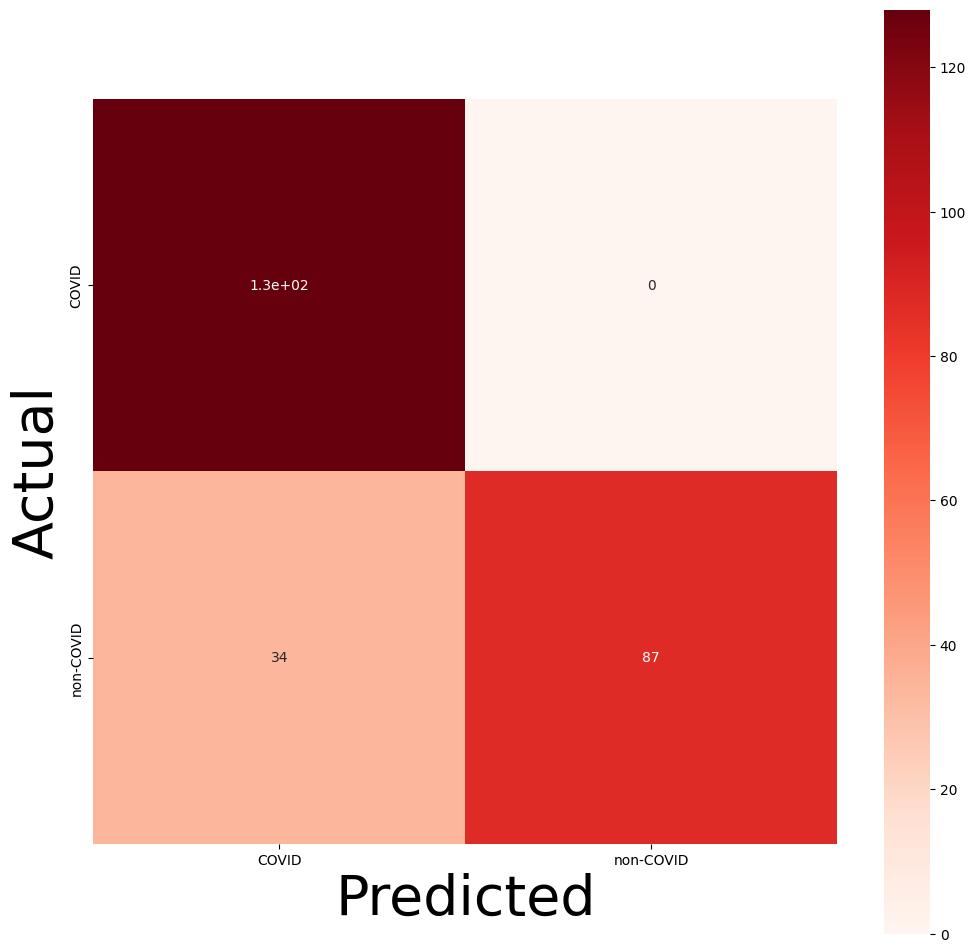

In [23]:
# Φτιάχνουμε ένα confusion matrix, όπου απεικονίζουμε την απόδοση του μοντέλου σε σχέση με την δεδομένη αλήθεια.
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Reds, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Plotting accuracy and loss curve

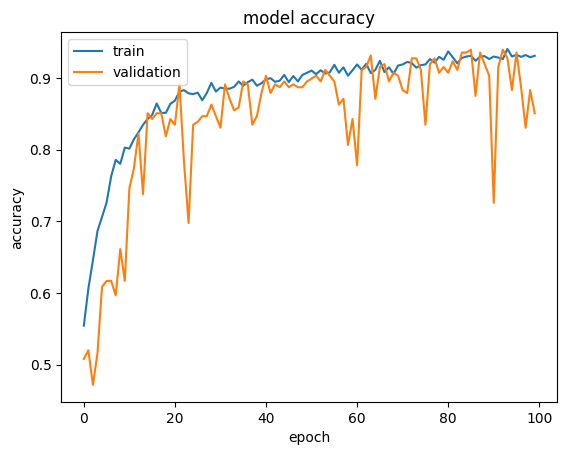

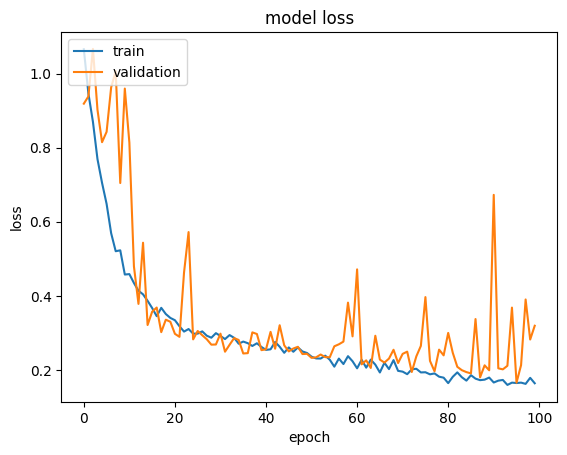

In [24]:
# accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Prediction on image

1/1 [==============================] - 1s 1s/step
[1.0000000e+00 3.4825116e-14]


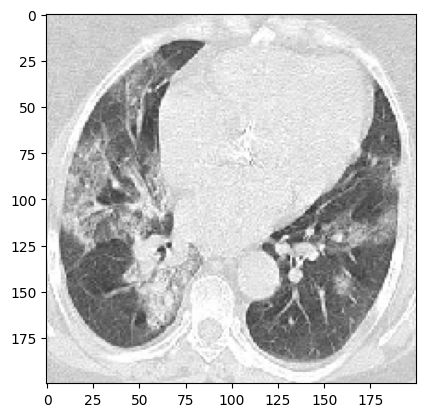

Prediction: Covid-19


In [25]:
from skimage import io
# from keras.preprocessing import image
import keras.utils as image

#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/SARS_COV-2_Ct-Scan_Dataset/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/SARS_COV-2_Ct-Scan_Dataset/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)

print('Prediction:',disease_class[ind])

## **Βιβλιογραφία**

[1] [Gao Huang, Zhuang Liu, et al, Densely Connected Convolutional Networks ](https://doi.org/10.48550/arXiv.1608.06993)

[2] [Alex Krizhevsky, et al, ImageNet Classification with Deep Convolutional Neural Networks](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

[3] [Tensorflow tutorials, data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)


[4] [Tensorflow tutorials, transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [ ]:
# Μετατροπή .ipynb σε .html
%%shell
jupyter nbconvert --to html /content/Covid_19_CT_scan_classification.ipynb

[NbConvertApp] Converting notebook /content/Covid_19_CT_scan_classification.ipynb to html
[NbConvertApp] Writing 1507382 bytes to /content/Covid_19_CT_scan_classification.html
